Vilka distansintervall till kollektivtrafik finns naturligt bland lekplatserna?

In [6]:
import requests
import json
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os

Öppnar filen med lekplatser och skapar en DF

In [29]:
current_dir = os.getcwd()
file_path = os.path.join(current_dir, "lekplatser_ny.json")
with open(file_path, "r", encoding="utf-8") as f:
    lekplatser_data = json.load(f)

lekplatser_df = pd.DataFrame([{
    'name': el.get('tags', {}).get('name', 'Okänd lekplats'),
    'lat': el['lat'],
    'lon': el['lon'],
    'typ': 'lekplats'
} for el in lekplatser_data])

Läs in hållplatser från koda

In [30]:
stop_df = pd.read_csv(os.path.join(current_dir, "stops.txt"))

stop_df = stop_df[
    (stop_df['stop_lat'] >= 57.5) & (stop_df['stop_lat'] <= 57.85) &
    (stop_df['stop_lon'] >= 11.7) & (stop_df['stop_lon'] <= 12.1)
]

stop_df = stop_df.drop_duplicates(subset='stop_name', keep='first')

stop_df = stop_df.rename(columns={
    'stop_name': 'name', 'stop_lat': 'lat', 'stop_lon': 'lon'
})

stop_df['typ'] = 'hållplats'

combined_df = pd.concat([lekplatser_df, stop_df[['name', 'lat', 'lon', 'typ']]], ignore_index=True)
lekplatser = combined_df[combined_df['typ'] == 'lekplats'].copy()
hållplatser = combined_df[combined_df['typ'] == 'hållplats'].copy()

Funktion för att beräkna avstånd till närmsta hållplats

In [31]:
# --- Beräkna avstånd till närmaste hållplats ---
def närmaste_avstånd(lat, lon, hållplatser):
    lekplats_pos = (lat, lon)
    return min(geodesic(lekplats_pos, (r['lat'], r['lon'])).meters for _, r in hållplatser.iterrows())

lekplatser['avstånd_m'] = lekplatser.apply(
    lambda row: närmaste_avstånd(row['lat'], row['lon'], hållplatser), axis=1
)

Välj ett k (utifrån elbow) och skriv kluster‑etiketter

In [32]:
k = 4  # sätt utifrån tester
km_final = KMeans(n_clusters=k, n_init="auto", random_state=0).fit(X)
lekplatser['cluster'] = km_final.fit_predict(X_scaled)

Sammanfattning

In [33]:
summary = lekplatser.groupby('cluster')['avstånd_m'].agg(
    ['count', 'mean', 'median', 'min', 'max']).round(1)
print("Avståndsprofil per kluster (meter):", summary)

Avståndsprofil per kluster (meter):          count   mean  median    min    max
cluster                                    
0           21  451.9   450.5  358.1  595.8
1           47  124.3   129.1   38.5  180.1
2            2  898.8   898.8  897.1  900.4
3           58  254.7   253.9  193.7  343.9


Visualisering

Text(0, 0.5, 'Silhouette-score')

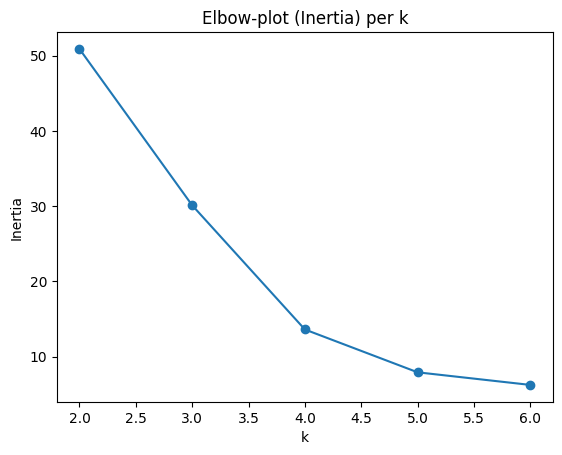

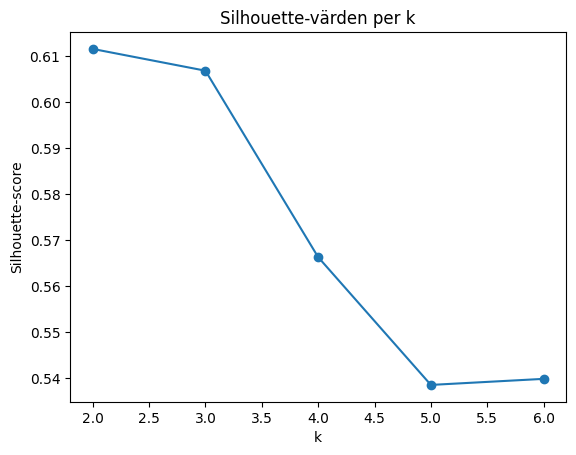

In [34]:


plt.figure()
plt.plot(df_metrics.index, df_metrics['inertia'], marker='o')
plt.title('Elbow-plot (Inertia) per k')
plt.xlabel('k')
plt.ylabel('Inertia')

plt.figure()
df_metrics['silhouette'].plot(marker='o')
plt.title('Silhouette-värden per k')
plt.xlabel('k')
plt.ylabel('Silhouette-score')

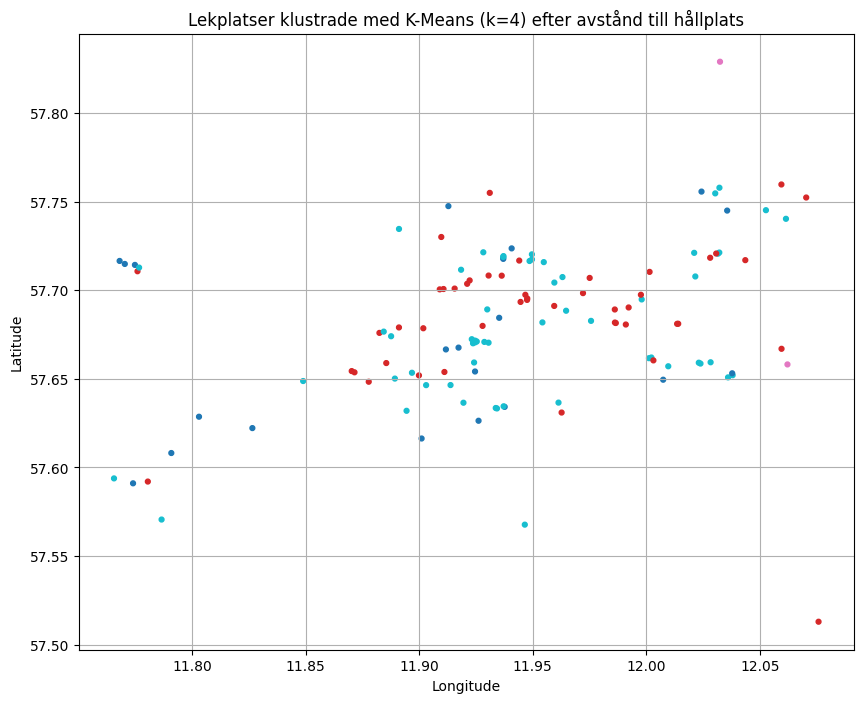

In [35]:
plt.figure(figsize=(10, 8))
plt.scatter(lekplatser['lon'], lekplatser['lat'], c=lekplatser['cluster'], cmap='tab10', s=12)
plt.title(f"Lekplatser klustrade med K-Means (k={k}) efter avstånd till hållplats")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)